In [1]:
import tkinter as tk
import numpy as np
import svgpathtools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tkinter import messagebox, colorchooser
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.path import Path

# Prototipo

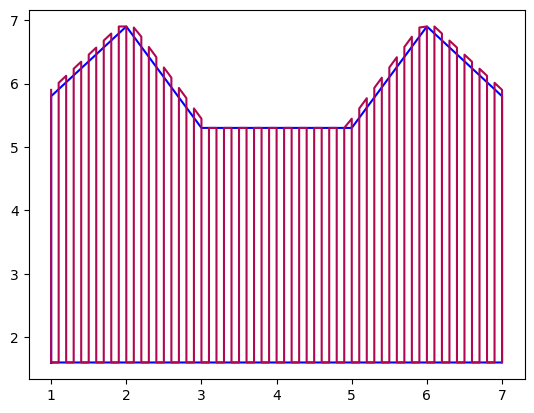

In [44]:
def load_svg():
    file_path = "./models/casa.svg"
    paths, _ = svgpathtools.svg2paths(file_path)
    process_svg(paths)

def process_svg(paths):
    trajectory = []
    for path in paths:
        for segment in path:
            points = np.linspace(0, 1, 100)
            for point in points:
                pos = segment.point(point)
                trajectory.append((pos.real, pos.imag))
    
    generate_printing_path(trajectory)

def validate_resolution():
    """Valida que la distancia entre puntos esté en el rango permitido."""
    try:
        value = float(resolution_entry.get())
        if 0.01 <= value <= 0.1:
            return value
        else:
            messagebox.showerror("Error", "La distancia entre puntos debe estar entre 0.01 y 0.1 mm.")
            resolution_entry.delete(0, tk.END)
            resolution_entry.insert(0, "0.1")  # Valor predeterminado
            return None
    except ValueError:
        messagebox.showerror("Error", "Ingrese un número válido para la distancia entre puntos.")
        resolution_entry.delete(0, tk.END)
        resolution_entry.insert(0, "0.1")
        return None

def generate_printing_path(trajectory):
    x, y = zip(*trajectory)
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)

    point_spacing = validate_resolution()
    if point_spacing is None:
        return  # No continuar si la validación falla

    printing_path = []
    
    x_current = x_min
    direction_y = -1
    while x_current <= x_max:
        y_positions = sorted({y_pos for x_pos, y_pos in trajectory if abs(x_pos - x_current) < point_spacing})
        if y_positions:
            if direction_y == -1:
                y_positions.reverse()
            for y_current in y_positions:
                if y_min <= y_current <= y_max:
                    printing_path.append((x_current, max(y_min, min(y_current, y_max))))
            direction_y *= -1
        x_current += point_spacing
    
    animate_trajectory(trajectory, printing_path)

def choose_color():
    """Permite al usuario seleccionar un color para la trayectoria."""
    color = colorchooser.askcolor(title="Selecciona un color")[1]
    if color:
        color_var.set(color)

def animate_trajectory(trajectory, printing_path):
    global canvas, ani, ax

    ax.clear()
    x, y = zip(*trajectory)
    x_print, y_print = zip(*printing_path)

    color = color_var.get()
    style = style_var.get()

    # Mapeo de estilos para matplotlib
    line_styles = {
        "Línea continua": "-",
        "Puntos": ":",
        "Línea entrecortada": "--",
        "Puntos y líneas": "-."
    }

    ax.plot(x, y, label='Contorno SVG', color='blue')
    line, = ax.plot([], [], label='Trayectoria de Impresión', color=color, linestyle=line_styles[style])

    def update(frame):
        if frame < len(x_print):
            line.set_data(x_print[:frame+1], y_print[:frame+1])
            return line,
        else:
            ani.event_source.stop()  # Detener animación al final
            return line,

    speed = float(speed_entry.get()) if speed_entry.get() else 50
    ani = animation.FuncAnimation(fig, update, frames=len(x_print), interval=speed, blit=True, repeat=False)
    canvas.draw()

def start_ui():
    global resolution_entry, speed_entry, color_var, style_var, canvas, fig, ax, root

    root = tk.Tk()
    root.title("3D Printer Configuration")

    control_frame = tk.Frame(root)
    control_frame.pack(side=tk.LEFT, padx=10, pady=10)

    tk.Label(control_frame, text="Distancia entre puntos (0.01 - 0.1 mm)").pack()
    resolution_entry = tk.Entry(control_frame)
    resolution_entry.pack()
    resolution_entry.insert(0, "0.1")

    tk.Label(control_frame, text="Velocidad de Animación (ms)").pack()
    speed_entry = tk.Entry(control_frame)
    speed_entry.pack()
    speed_entry.insert(0, "10")

    tk.Label(control_frame, text="Color de la línea").pack()
    color_var = tk.StringVar(value="black")  # Valor inicial negro
    color_button = tk.Button(control_frame, text="Seleccionar Color", command=choose_color)
    color_button.pack()

    tk.Label(control_frame, text="Estilo de trayectoria").pack()
    style_var = tk.StringVar(value="Línea continua")
    style_options = ["Línea continua", "Puntos", "Línea entrecortada", "Puntos y líneas"]
    style_menu = tk.OptionMenu(control_frame, style_var, *style_options)
    style_menu.pack()

    load_button = tk.Button(control_frame, text="Cargar Archivo SVG", command=load_svg)
    load_button.pack()

    fig, ax = plt.subplots()
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    
    root.mainloop()

if __name__ == "__main__":
    start_ui()


# Versión 1.0

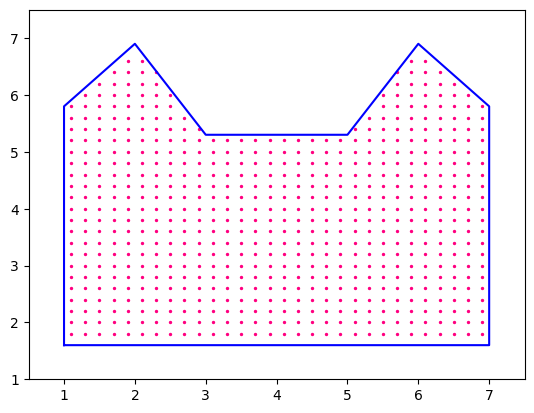

In [3]:
def load_svg():
    file_name = svg_var.get()
    if not file_name:
        return
    file_path = f"./models/{file_name}"
    paths, _ = svgpathtools.svg2paths(file_path)
    process_svg(paths, file_name)

def process_svg(paths, file_name):
    contour = []
    for path in paths:
        for segment in path:
            points = np.linspace(0, 1, 100)
            for point in points:
                pos = segment.point(point)
                contour.append((pos.real, pos.imag))
    fill_shape(contour, file_name)

def validate_resolution():
    try:
        value = float(resolution_entry.get())
        if 0.1 <= value <= 0.5:
            return value
        else:
            messagebox.showerror("Error", "La distancia debe estar entre 0.1 y 0.5 mm.")
            return None
    except ValueError:
        messagebox.showerror("Error", "Ingrese un número válido.")
        return None

def validate_speed():
    try:
        value = int(speed_entry.get())
        if value > 0:
            return value
        else:
            messagebox.showerror("Error", "La velocidad debe ser un número positivo.")
            return None
    except ValueError:
        messagebox.showerror("Error", "Ingrese un número válido para la velocidad.")
        return None

def choose_color():
    global point_color
    color = colorchooser.askcolor()[1]
    if color:
        point_color = color

def fill_shape(contour, file_name):
    x, y = zip(*contour)

    point_spacing = validate_resolution()
    if point_spacing is None:
        return

    path = Path(contour, closed=True)
    filling_points = []
    
    if file_name == "casa.svg":
        x_range, y_range = (0.5, 7.5), (1, 7.5)
    else:
        x_range, y_range = (0, 10), (-1, 8)

    x_grid = np.arange(x_range[0], x_range[1], point_spacing)
    y_grid = np.arange(y_range[0], y_range[1], point_spacing)
    direction = 1
    for x_val in x_grid:
        y_sorted = y_grid if direction == 1 else y_grid[::-1]
        for y_val in y_sorted:
            if path.contains_point((x_val, y_val)):
                filling_points.append((x_val, y_val))
        direction *= -1
    
    animate_trajectory(contour, filling_points, x_range, y_range)

def animate_trajectory(contour, filling_points, x_range, y_range):
    ax.clear()
    x_contour, y_contour = zip(*contour)
    x_fill, y_fill = zip(*filling_points) if filling_points else ([], [])
    
    ax.plot(x_contour, y_contour, color='blue')
    scatter = ax.scatter([], [], color=point_color, s=2)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    speed = validate_speed()
    if speed is None:
        return
    
    def update(frame):
        if frame < len(x_fill):
            scatter.set_offsets(np.c_[x_fill[:frame+1], y_fill[:frame+1]])
        return scatter,
    
    ani = animation.FuncAnimation(fig, update, frames=len(x_fill), interval=speed, blit=True, repeat=False)
    canvas.draw()

def start_ui():
    global resolution_entry, speed_entry, svg_var, canvas, fig, ax, root, point_color

    root = tk.Tk()
    root.title("Grupo 3 - Impresora 3D")
    root.configure(bg='black')
    root.option_add('*TButton*background', 'crimson')
    root.option_add('*TButton*foreground', 'white')
    root.option_add('*TLabel*foreground', 'white')
    root.option_add('*TEntry*foreground', 'black')
    root.option_add('*TEntry*background', 'white')
    root.option_add('*TFrame*background', 'black')
    root.option_add('*OptionMenu*foreground', 'white')
    root.option_add('*OptionMenu*background', 'crimson')
    root.option_add('*Menu*foreground', 'white')
    root.option_add('*Menu*background', 'crimson')
    root.configure(highlightbackground='black', highlightcolor='black', highlightthickness=2)
    
    control_frame = tk.Frame(root, bg='black')
    control_frame.pack(side=tk.LEFT, padx=10, pady=10)

    tk.Label(control_frame, text="Seleccionar archivo SVG", bg='black', fg='white').pack()
    svg_var = tk.StringVar(value="forma1.svg")
    svg_options = ["avion.svg", "casa.svg", "forma1.svg", "forma2.svg"]
    svg_menu = tk.OptionMenu(control_frame, svg_var, *svg_options)
    svg_menu.config(bg='crimson', fg='white')
    svg_menu.pack()

    tk.Label(control_frame, text="Distancia entre puntos (0.1 - 0.5 mm)", bg='black', fg='white').pack()
    resolution_entry = tk.Entry(control_frame)
    resolution_entry.pack()
    resolution_entry.insert(0, "0.1")
    
    tk.Label(control_frame, text="Velocidad de animación (ms)", bg='black', fg='white').pack()
    speed_entry = tk.Entry(control_frame)
    speed_entry.pack()
    speed_entry.insert(0, "10")

    color_button = tk.Button(control_frame, text="Seleccionar Color", command=choose_color, bg='crimson', fg='white')
    color_button.pack()

    load_button = tk.Button(control_frame, text="Cargar SVG", command=load_svg, bg='crimson', fg='white')
    load_button.pack()

    fig, ax = plt.subplots()
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    
    point_color = 'red'
    root.mainloop()

if __name__ == "__main__":
    start_ui()

# Versión 2.0 con pantalla de carga :D

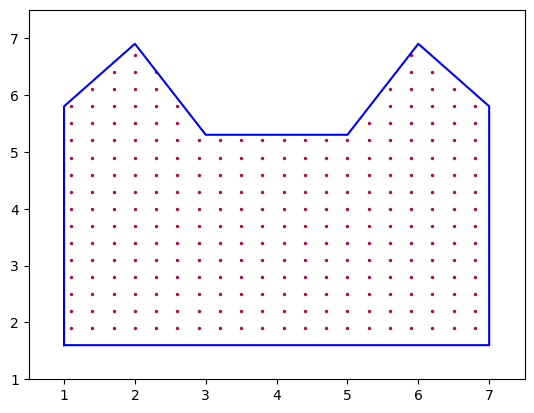

In [18]:
import tkinter as tk
import numpy as np
import svgpathtools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tkinter import messagebox, colorchooser
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.path import Path
import time

def show_loading_screen():
    loading_root = tk.Tk()
    loading_root.overrideredirect(True)
    loading_root.configure(bg='black')
    loading_root.geometry("300x150+500+300")
    
    loading_label = tk.Label(loading_root, text="Cargando... 0%", font=("Arial", 14), fg='white', bg='black')
    loading_label.pack(expand=True)
    
    def update_progress():
        for i in range(1, 101):
            loading_label.config(text=f"Cargando... {i}%", fg='red')
            loading_root.update()
            time.sleep(0.02)  # 2 segundos en total (100 * 0.02)
        loading_root.destroy()
    
    loading_root.after(100, update_progress)
    loading_root.mainloop()

def load_svg():
    file_name = svg_var.get()
    if not file_name:
        return
    file_path = f"./models/{file_name}"
    paths, _ = svgpathtools.svg2paths(file_path)
    process_svg(paths, file_name)

def process_svg(paths, file_name):
    contour = []
    for path in paths:
        for segment in path:
            points = np.linspace(0, 1, 100)
            for point in points:
                pos = segment.point(point)
                contour.append((pos.real, pos.imag))
    fill_shape(contour, file_name)

def validate_resolution():
    try:
        value = float(resolution_entry.get())
        if 0.1 <= value <= 0.5:
            return value
        else:
            messagebox.showerror("Error", "La distancia debe estar entre 0.1 y 0.5 mm.")
            return None
    except ValueError:
        messagebox.showerror("Error", "Ingrese un número válido.")
        return None

def validate_speed():
    try:
        value = int(speed_entry.get())
        if value > 0:
            return value
        else:
            messagebox.showerror("Error", "La velocidad debe ser un número positivo.")
            return None
    except ValueError:
        messagebox.showerror("Error", "Ingrese un número válido para la velocidad.")
        return None

def choose_color():
    global point_color
    color = colorchooser.askcolor()[1]
    if color:
        point_color = color

def fill_shape(contour, file_name):
    x, y = zip(*contour)
    point_spacing = validate_resolution()
    if point_spacing is None:
        return
    path = Path(contour, closed=True)
    filling_points = []
    
    if file_name == "casa.svg":
        x_range, y_range = (0.5, 7.5), (1, 7.5)
    else:
        x_range, y_range = (0, 10), (-1, 8)
    
    x_grid = np.arange(x_range[0], x_range[1], point_spacing)
    y_grid = np.arange(y_range[0], y_range[1], point_spacing)
    direction = 1
    for x_val in x_grid:
        y_sorted = y_grid if direction == 1 else y_grid[::-1]
        for y_val in y_sorted:
            if path.contains_point((x_val, y_val)):
                filling_points.append((x_val, y_val))
        direction *= -1
    
    animate_trajectory(contour, filling_points, x_range, y_range)

def animate_trajectory(contour, filling_points, x_range, y_range):
    ax.clear()
    x_contour, y_contour = zip(*contour)
    x_fill, y_fill = zip(*filling_points) if filling_points else ([], [])
    
    ax.plot(x_contour, y_contour, color='blue')
    scatter = ax.scatter([], [], color=point_color, s=2)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    speed = validate_speed()
    if speed is None:
        return
    
    def update(frame):
        if frame < len(x_fill):
            scatter.set_offsets(np.c_[x_fill[:frame+1], y_fill[:frame+1]])
        return scatter,
    
    ani = animation.FuncAnimation(fig, update, frames=len(x_fill), interval=speed, blit=True, repeat=False)
    canvas.draw()

def start_ui():
    show_loading_screen()
    
    global resolution_entry, speed_entry, svg_var, canvas, fig, ax, root, point_color

    root = tk.Tk()
    root.title("Grupo 3 - Impresora 3D")
    root.configure(bg='black')
    root.option_add('*TButton*background', 'crimson')
    root.option_add('*TButton*foreground', 'white')
    root.option_add('*TLabel*foreground', 'white')
    root.option_add('*TEntry*foreground', 'black')
    root.option_add('*TEntry*background', 'white')
    root.option_add('*TFrame*background', 'black')
    root.option_add('*OptionMenu*foreground', 'white')
    root.option_add('*OptionMenu*background', 'crimson')
    root.option_add('*Menu*foreground', 'white')
    root.option_add('*Menu*background', 'crimson')
    root.configure(highlightbackground='black', highlightcolor='black', highlightthickness=2)
    
    control_frame = tk.Frame(root, bg='black')
    control_frame.pack(side=tk.LEFT, padx=10, pady=10)
    
    tk.Label(control_frame, text="Seleccionar archivo SVG", bg='black', fg='white').pack()
    svg_var = tk.StringVar(value="forma1.svg")
    svg_options = ["avion.svg", "casa.svg", "forma1.svg", "forma2.svg"]
    svg_menu = tk.OptionMenu(control_frame, svg_var, *svg_options)
    svg_menu.config(bg='crimson', fg='white')
    svg_menu.pack()
    
    tk.Label(control_frame, text="Distancia entre puntos (0.1 - 0.5 mm)", bg='black', fg='white').pack()
    resolution_entry = tk.Entry(control_frame)
    resolution_entry.pack()
    resolution_entry.insert(0, "0.1")
    
    tk.Label(control_frame, text="Velocidad de animación (ms)", bg='black', fg='white').pack()
    speed_entry = tk.Entry(control_frame)
    speed_entry.pack()
    speed_entry.insert(0, "10")
    
    color_button = tk.Button(control_frame, text="Seleccionar Color", command=choose_color, bg='crimson', fg='white')
    color_button.pack()
    
    load_button = tk.Button(control_frame, text="Cargar SVG", command=load_svg, bg='crimson', fg='white')
    load_button.pack()
    
    fig, ax = plt.subplots()
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    
    point_color = 'red'
    root.mainloop()

if __name__ == "__main__":
    start_ui()